In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# Data preprocessing
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

In [0]:
# For imputing missing values for level_binary
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingClassifier

In [0]:
# Libraries for predicting
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

In [0]:
# For imputation
from sklearn.ensemble import RandomForestClassifier
from statistics import mode

In [0]:
# Libraries for hyperparameter optimization
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [0]:
# Libraries for feature selection
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC, LinearSVR

In [30]:
# Keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [0]:
#To save the final model
import pickle

In [10]:
!wget https://raw.githubusercontent.com/avinashkz/canvass_challenge/master/results/processed_data/forecasting_processed.csv

--2018-07-21 20:38:54--  https://raw.githubusercontent.com/avinashkz/canvass_challenge/master/results/processed_data/forecasting_processed.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 723063 (706K) [text/plain]
Saving to: ‘forecasting_processed.csv’

forecasting_process 100%[===================>] 706.12K  --.-KB/s    in 0.09s   

2018-07-21 20:38:54 (7.57 MB/s) - ‘forecasting_processed.csv’ saved [723063/723063]



In [0]:
#Load data
reg_data = pd.read_csv("forecasting_processed.csv")

In [13]:
reg_data.shape

(8415, 15)

In [14]:
reg_data.head()

,time_stamp,y,co_gt,nhmc,c6h6,s2,nox,s3,no2,s4,s5,t,rh,ah,level
0,2004-03-10T12:30:00Z,1185,2.6,150.0,11.9,NaN,166.0,1056.0,113.0,1692.0,NaN,13.6,48.9,0.7578,High
1,2004-03-10T13:30:00Z,1136,2.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,High
2,2004-03-10T14:30:00Z,1094,2.2,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,NaN,0.7502,NaN
3,2004-03-10T15:30:00Z,1010,2.2,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,High
4,2004-03-10T16:30:00Z,1011,1.6,51.0,6.5,836.0,131.0,1205.0,116.0,NaN,1110.0,NaN,59.6,0.7888,High


In [22]:
! mkdir results
! mkdir results/pickles

mkdir: cannot create directory ‘results/pickles’: File exists


In [0]:
def process_data(X, refit = False):

    fixed_values = {}
    
    all_data = X.loc[:, ['co_gt', 'nhmc', 'c6h6',
                         's2', 'nox', 's3', 'no2',
                         's4', 's5', 't','rh', 'ah',
                         'level']].copy()
    
    #I have made the assumption that the difference between all the levels are the same. 
    all_data["level"] = all_data["level"].map( {'Very low': -2, 'Low':-1, 'Moderate':0, 'High':1, 'Very High':2 } )
    
    feat = [np.abs(item)[item != 1] for item in [all_data.corr()[item] for item in all_data.columns]]

    for c,columns in enumerate(feat):

        col_name = pd.DataFrame(columns).columns[0]

        print("==== Processing {} ====".format(col_name))
        
        sorted_col = pd.DataFrame(columns).sort_values(col_name)

        top_corr = sorted_col.iloc[-1].name
        second_corr = sorted_col.iloc[-2].name
        third_corr = sorted_col.iloc[-3].name

        features = [top_corr, second_corr, third_corr]
        
        y = all_data.loc[:, col_name]
        x1 = all_data.loc[:, top_corr]
        x2 = all_data.loc[:, second_corr]
        x3 = all_data.loc[:, third_corr]

        if refit:        

            print(" \t Fitting")
            for number, item in enumerate([x1, x2, x3]):   
                X_train = item[np.invert(y.isnull() | item.isnull())].values.reshape(-1, 1)
                y_train = y[np.invert(y.isnull() | item.isnull())]

                #Select Classifier or Regression model based on the number of unique values
                if(len(y.unique()) <= 7):
                    rf_model = RandomForestClassifier()
                    if y_train[0] < 1 : 
                        y_train = y_train*100
                    y_train = y_train.astype('int')

                    fixed_values[col_name] = mode(y)

                else:
                    rf_model = RandomForestRegressor()

                    fixed_values[col_name] = np.mean(y)

                # Fitting Random forest model
                rf_model.fit(X_train, y_train)


                with open('results/pickles/{}-{}x.pickle'.format(col_name, number), 'wb') as save_model:
                    pickle.dump(rf_model, save_model)

            with open('results/pickles/fixed_values2.pickle', 'wb') as save_model:
                pickle.dump(fixed_values, save_model)

        print(" \t Imputing \n")

        # Data missing selected feature
        fallback_1 = y.isnull() & np.invert(x1.isnull())
        fallback_2 = y.isnull() & x1.isnull() & np.invert(x2.isnull())
        fallback_3 = y.isnull() & x1.isnull() &  x2.isnull() & np.invert(x3.isnull())
        fallback_4 = y.isnull() & x1.isnull() &  x2.isnull() & x3.isnull()
        fallbacks = [fallback_1, fallback_2, fallback_3, fallback_4]

        complete_data = all_data.loc[np.invert(y.isnull())].copy()

        for count, item in enumerate(fallbacks):
            if item.sum().astype("bool") & (count < 3):
                loop_data = all_data.loc[item].copy()
                with open('results/pickles/{}-{}x.pickle'.format(col_name, count), 'rb') as load_model:
                    rf_model = pickle.load(load_model)

                x_data = loop_data.loc[:, features[count]].values.reshape(-1, 1)

                #Predicting using Random forest model
                y_data = rf_model.predict(x_data)

                loop_data.loc[:,col_name] = y_data

                complete_data = complete_data.append(loop_data)

            else:

                #warnings.warn("There are more than 3 missing values in one or more records")

                loop_data = all_data.loc[item].copy()

                with open('results/pickles/fixed_values2.pickle'.format(col_name, count), 'rb') as load_model:
                    fixed_values = pickle.load(load_model)

                # Imputing with preset values as more than 4 values are missing.
                y_data = fixed_values[col_name]
                loop_data.loc[:,col_name] = y_data
                complete_data = complete_data.append(loop_data)

        all_data = complete_data.copy()

    all_data = all_data.sort_index()
    
    #Binarizing variables
    lb = LabelBinarizer()
    for col in all_data:
        target = all_data[col]
        if(len(target.unique()) <= 7):
            binary_data = lb.fit_transform(target)
            unique_vals = all_data[col].unique()
            unique_vals.sort()
            col_names = [col + '_' +str(int(item)) for item in unique_vals if item is not np.nan]
            all_data = pd.concat([all_data, pd.DataFrame(binary_data, columns= col_names)], axis = 1)
            all_data.drop([col], axis = 1, inplace = True)
    
    
    return all_data

In [24]:
X = process_data(reg_data, refit=True)

==== Processing co_gt ====
 	 Fitting
 	 Imputing 

==== Processing nhmc ====
 	 Fitting


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


 	 Imputing 

==== Processing c6h6 ====
 	 Fitting


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


 	 Imputing 

==== Processing s2 ====
 	 Fitting


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


 	 Imputing 

==== Processing nox ====
 	 Fitting
 	 Imputing 

==== Processing s3 ====
 	 Fitting


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


 	 Imputing 

==== Processing no2 ====
 	 Fitting
 	 Imputing 

==== Processing s4 ====
 	 Fitting


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


 	 Imputing 

==== Processing s5 ====
 	 Fitting


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


 	 Imputing 

==== Processing t ====
 	 Fitting


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


 	 Imputing 

==== Processing rh ====
 	 Fitting


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


 	 Imputing 

==== Processing ah ====
 	 Fitting


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


 	 Imputing 

==== Processing level ====
 	 Fitting
 	 Imputing 



/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


In [0]:
y = reg_data['y']

In [0]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=7)

# Train validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=7)

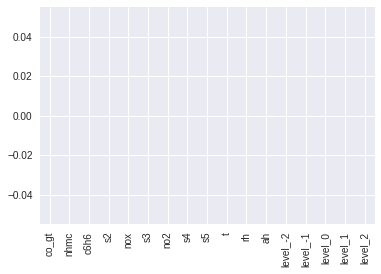

In [25]:
X.isnull().sum().plot(kind='bar')

In [28]:
X.head()

,co_gt,nhmc,c6h6,s2,nox,s3,no2,s4,s5,t,rh,ah,level_-2,level_-1,level_0,level_1,level_2
0,2.6,150.0,11.9,927.811429,166.0,1056.0,113.0,1692.000000,974.514482,13.60,48.900000,0.7578,0,0,0,1,0
1,2.0,112.0,9.4,955.000000,103.0,1174.0,92.0,1559.000000,972.000000,13.30,47.700000,0.7255,0,0,0,1,0
2,2.2,88.0,9.0,939.000000,131.0,1140.0,114.0,1555.000000,1074.000000,11.90,28.058095,0.7502,0,0,0,1,0
3,2.2,80.0,9.2,948.000000,172.0,1092.0,122.0,1584.000000,1203.000000,11.00,60.000000,0.7867,0,0,0,1,0
4,1.6,51.0,6.5,836.000000,131.0,1205.0,116.0,1468.929042,1110.000000,12.97,59.600000,0.7888,0,0,0,1,0


In [0]:
def evaluate(model): 
    '''
    Function prints the training and validation scores.
    Args
        Model: Sklearn object with predict method.
    
    Returns
        None
    '''
    model.fit(X_train, y_train)
    train_rmse = np.sqrt(mean_squared_error(y_pred=model.predict(X_train),y_true=y_train))
    val_rmse = np.sqrt(mean_squared_error(y_pred=model.predict(X_val),y_true=y_val))
    print("Train RMSE: ", train_rmse)
    print("Validation RMSE: ", val_rmse)

# Keras

In [0]:
scalarX = MinMaxScaler()
scalarX.fit(X_train)
Xs_train = scalarX.transform(X_train)
Xs_val = scalarX.transform(X_val)
Xs_test = scalarX.transform(X_test)

In [37]:
model = Sequential()
model.add(Dense(20, input_dim=17, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(Xs_train, y_train, epochs=20, verbose=0)

In [40]:
evaluate(model)

262.63143683876973

# Test RMSE

In [71]:
np.sqrt(mean_squared_error(y_pred=model.predict(X_test),y_true=y_test))

253.968110938304